<a href="https://colab.research.google.com/github/WHARN0/Pembelajaran-Mesin/blob/main/Jobsheet_10_Recurrent_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Praktikum 1**

## **RNN untuk Analisis Sentimen**

### **Setup**

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
 plt.plot(history.history[metric])
 plt.plot(history.history['val_'+metric], '')
 plt.xlabel("Epochs")
 plt.ylabel(metric)
 plt.legend([metric, 'val_'+metric])

### **Setup input pipeline**

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b"In spite of the great future-design touches, the clever Asimov premise, and Will Smith's dependable cool performance, this movie doesn't live up to expectations. The clich\xc3\xa9s come thick and fast; (waking from a recurring nightmare, maverick cop has his badge revoked by hardass lieutenant, to list more would be spoiling it - you can see the end a mile off). This movie is also stagebound - you never feel that you have travelled anywhere; what's supposed to be a global disaster never leaves an obviously CGI Chicago. The robots themselves are good in closeup, but the 'crowd' scenes look more like bad Disney -the CGI is overdone again and again. And if you can destroy the robots by smashing them, why do they need to inject 'nanites'? You know it's a duff movie when stupid questions like that start to bother you before the climax. It could have been great, but it's less than the sum of its parts, mainly due to the utterly predictable plot that could have come from any action

### **Buat Teks Encoder**

In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [7]:
vocab=np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [8]:
encoded_example=encoder(example)[:3].numpy()
encoded_example

array([[  8,   1,   5, ...,   0,   0,   0],
       [ 10, 469, 192, ...,   0,   0,   0],
       [195,  63, 492, ...,   0,   0,   0]])

In [9]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"In spite of the great future-design touches, the clever Asimov premise, and Will Smith's dependable cool performance, this movie doesn't live up to expectations. The clich\xc3\xa9s come thick and fast; (waking from a recurring nightmare, maverick cop has his badge revoked by hardass lieutenant, to list more would be spoiling it - you can see the end a mile off). This movie is also stagebound - you never feel that you have travelled anywhere; what's supposed to be a global disaster never leaves an obviously CGI Chicago. The robots themselves are good in closeup, but the 'crowd' scenes look more like bad Disney -the CGI is overdone again and again. And if you can destroy the robots by smashing them, why do they need to inject 'nanites'? You know it's a duff movie when stupid questions like that start to bother you before the climax. It could have been great, but it's less than the sum of its parts, mainly due to the utterly predictable plot that could have come from any acti

### **Buat Model**

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [11]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [12]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[0.00090929]


In [13]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 195ms/step
[0.00090929]


In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### **Train Model**

In [16]:
history = model.fit(train_dataset, epochs=10,
validation_data=test_dataset,
validation_steps=30)

Epoch 1/10
391/391 [==============================] - 227s 563ms/step - loss: 0.6559 - accuracy: 0.5543 - val_loss: 0.5443 - val_accuracy: 0.7172
Epoch 2/10
391/391 [==============================] - 220s 562ms/step - loss: 0.5665 - accuracy: 0.7404 - val_loss: 0.5896 - val_accuracy: 0.7510
Epoch 3/10
391/391 [==============================] - 219s 559ms/step - loss: 0.4769 - accuracy: 0.7960 - val_loss: 0.4137 - val_accuracy: 0.8120
Epoch 4/10
391/391 [==============================] - 218s 558ms/step - loss: 0.3780 - accuracy: 0.8309 - val_loss: 0.3678 - val_accuracy: 0.8302
Epoch 5/10
391/391 [==============================] - 218s 557ms/step - loss: 0.3461 - accuracy: 0.8470 - val_loss: 0.3492 - val_accuracy: 0.8391
Epoch 6/10
391/391 [==============================] - 216s 552ms/step - loss: 0.3292 - accuracy: 0.8558 - val_loss: 0.3393 - val_accuracy: 0.8453
Epoch 7/10
391/391 [==============================] - 220s 563ms/step - loss: 0.3186 - accuracy: 0.8613 - val_loss: 0.3312 -

In [17]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 64s 164ms/step - loss: 0.3221 - accuracy: 0.8649
Test Loss: 0.32213470339775085
Test Accuracy: 0.8648800253868103


(0.0, 0.6736382186412812)

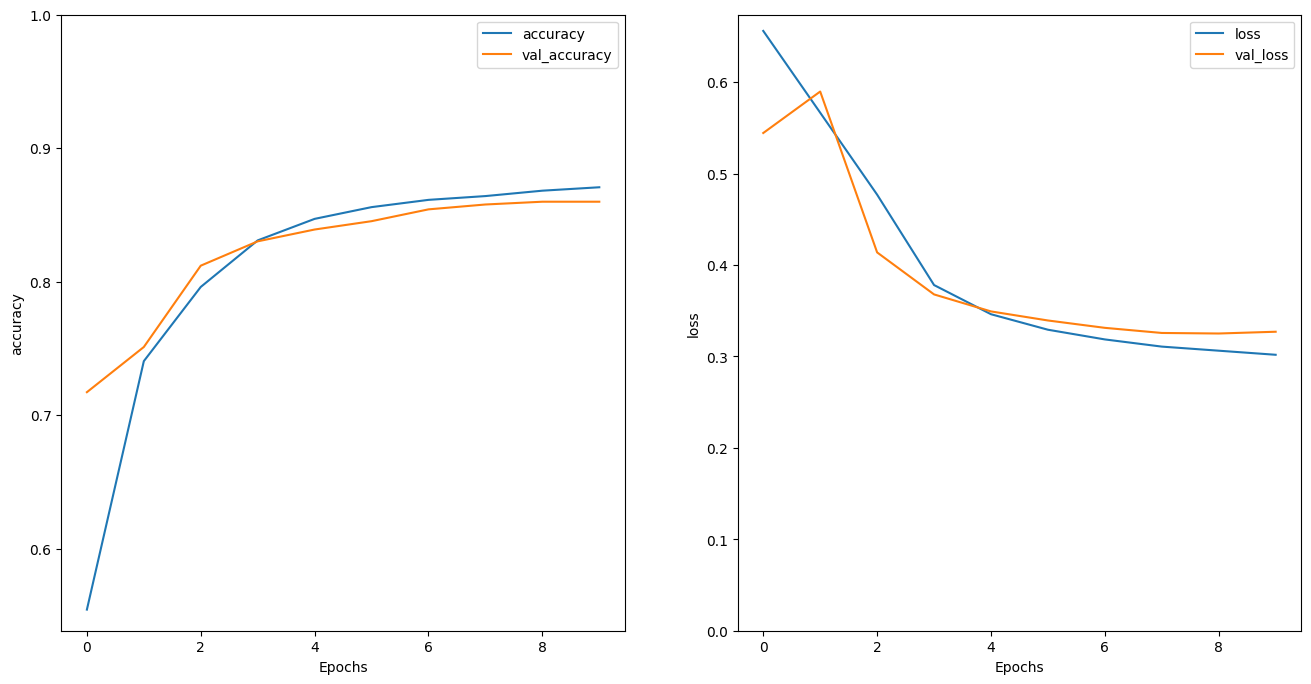

In [18]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [19]:
sample_text = ('The movie was cool. The animation and the graphics '
'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


### **Stack two or more LSTM layers**

In [20]:
model = tf.keras.Sequential([
 encoder,
 tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
 tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
 tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
 tf.keras.layers.Dense(64, activation='relu'),
 tf.keras.layers.Dropout(0.5),
 tf.keras.layers.Dense(1)
])

In [21]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
 optimizer=tf.keras.optimizers.Adam(1e-4),
 metrics=['accuracy'])

In [22]:
history = model.fit(train_dataset, epochs=10,
 validation_data=test_dataset,
 validation_steps=30)

Epoch 1/10
391/391 [==============================] - 444s 1s/step - loss: 0.6395 - accuracy: 0.5744 - val_loss: 0.4662 - val_accuracy: 0.8031
Epoch 2/10
391/391 [==============================] - 430s 1s/step - loss: 0.4036 - accuracy: 0.8228 - val_loss: 0.3718 - val_accuracy: 0.8401
Epoch 3/10
391/391 [==============================] - 423s 1s/step - loss: 0.3451 - accuracy: 0.8531 - val_loss: 0.3491 - val_accuracy: 0.8370
Epoch 4/10
391/391 [==============================] - 425s 1s/step - loss: 0.3253 - accuracy: 0.8634 - val_loss: 0.3271 - val_accuracy: 0.8562
Epoch 5/10
391/391 [==============================] - 424s 1s/step - loss: 0.3127 - accuracy: 0.8700 - val_loss: 0.3318 - val_accuracy: 0.8505
Epoch 6/10
391/391 [==============================] - 420s 1s/step - loss: 0.3101 - accuracy: 0.8687 - val_loss: 0.3340 - val_accuracy: 0.8406
Epoch 7/10
391/391 [==============================] - 423s 1s/step - loss: 0.3059 - accuracy: 0.8700 - val_loss: 0.3322 - val_accuracy: 0.8365

In [23]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 114s 290ms/step - loss: 0.3190 - accuracy: 0.8514
Test Loss: 0.3189893364906311
Test Accuracy: 0.851360023021698


In [24]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-1.9544512]]


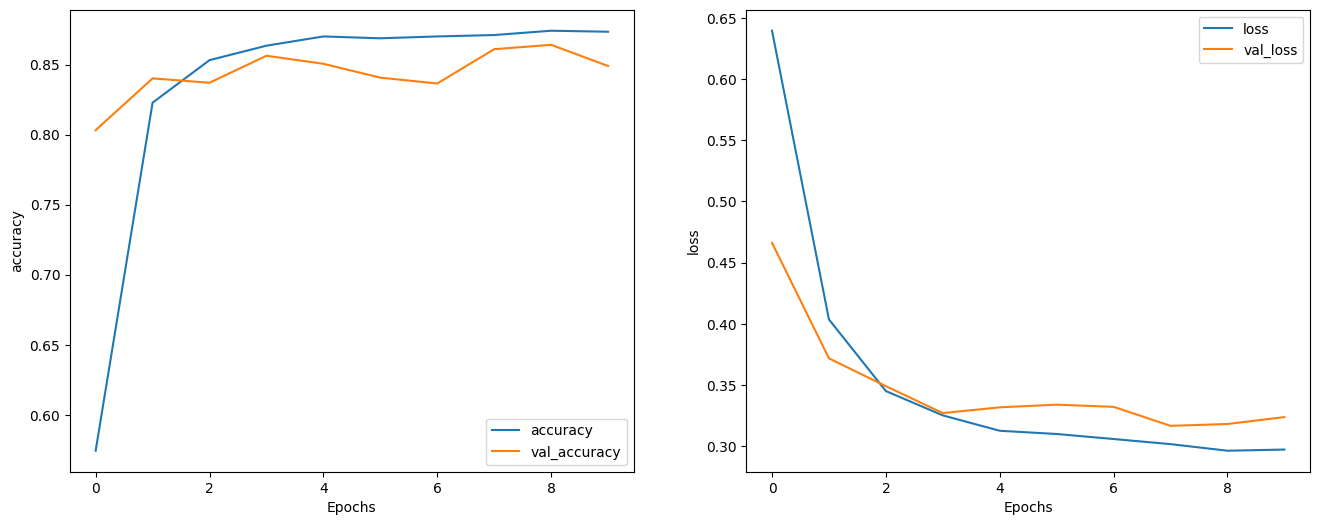

In [25]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# **Praktikum 2**

## **Generator Teks dengan RNN**

### **Setup**

Import TensorFlow

In [26]:
import tensorflow as tf
import numpy as np
import os
import time

Download Dataset Shakespeare

In [27]:
path_to_file=tf.keras.utils.get_file('shakespeare.txt','https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


Load Data

In [28]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [29]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [30]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


### **Olah Teks**

Vectorize Teks

In [31]:
example_texts=['abcdefg','xyz']
chars=tf.strings.unicode_split(example_texts,input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [32]:
ids_from_chars=tf.keras.layers.StringLookup(
vocabulary=list(vocab),mask_token=None)

In [33]:
ids=ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [34]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [35]:
chars=chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [36]:
tf.strings.reduce_join(chars,axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [37]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

Prediksi

Diberikan sebuah karakter, atau serangkaian karakter, karakter apa yang paling mungkin berikutnya? Ini adalah tugas yang harus Anda latih agar model dapat melakukannya. Masukan ke model akan berupa urutan karakter, dan Anda melatih model untuk memprediksi keluaran berupa karakter berikut pada setiap langkah waktu. Karena RNN mempertahankan keadaan internal yang bergantung pada elemen yang terlihat sebelumnya, mengingat semua karakter dihitung hingga saat ini, karakter apa selanjutnya?

Membuat Trianing Set dan Target

Selanjutnya bagilah teks menjadi contoh sequence. Setiap masukan sequence akan berisi karakter seq_length dari teks. Untuk setiap masukan sequence, target prediksi berisi teks dengan panjang yang sama, hanya digeser satu karakter ke kanan. Jadi, bagi teks menjadi beberapa bagian seq_length+1. Misalnya, seq_length adalah 4 dan teks kita adalah "Hello". Urutan masukannya adalah "Hell", dan urutan targetnya adalah "ello". Untuk melakukan ini, pertama-tama gunakan fungsi tf.data.Dataset.from_tensor_slices untuk mengonversi vektor teks menjadi aliran indeks karakter.

In [38]:
all_ids=ids_from_chars(tf.strings.unicode_split(text,'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [39]:
ids_dataset=tf.data.Dataset.from_tensor_slices(all_ids)

In [40]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [41]:
seq_length=100

In [42]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [43]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [44]:
def split_input_target(sequence):
  input_text=sequence[:-1]
  target_text=sequence[1:]
  return input_text,target_text

In [45]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [46]:
dataset=sequences.map(split_input_target)

In [47]:
for input_example,target_example in dataset.take(1):
  print("Input :",text_from_ids(input_example).numpy())
  print("Target:",text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


Membuat Batch Training

In [48]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

### **Buat Model**

In [49]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [50]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [51]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

### **Uji Model**

In [52]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [53]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense_4 (Dense)             multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [54]:
sampled_indices=tf.random.categorical(example_batch_predictions[0],num_samples=1)
sampled_indices=tf.squeeze(sampled_indices,axis=-1).numpy()

In [55]:
sampled_indices

array([28, 31,  5, 64, 23, 38, 14,  4, 41,  9, 62,  5, 62, 19, 56, 36, 17,
        6, 14, 48, 26, 12, 29,  9, 30, 34, 10, 18,  5, 11, 10, 16, 55, 28,
       34, 32,  0, 19, 55, 28,  2, 27, 63, 26, 23, 13, 43, 65, 10, 11, 55,
       13, 52,  0, 24, 49, 64, 44, 41, 31, 25, 28,  3, 45,  9, 17, 55, 22,
       31, 38,  3, 51,  0, 48, 27, 27, 40, 45, 45, 62,  7, 51,  1, 59, 23,
       25, 26, 50,  7,  9,  0, 65, 50, 34, 41, 51,  5, 52, 23, 21])

In [56]:
print("Input:\n",text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n",text_from_ids(sampled_indices).numpy())

Input:
 b"full intent\nTo dash our late decree in parliament\nTouching King Henry's oath and your succession.\nSh"

Next Char Predictions:
 b"OR&yJYA$b.w&wFqWD'AiM;P.QU3E&:3CpOUS[UNK]FpO NxMJ?dz3:p?m[UNK]KjyebRLO!f.DpIRY!l[UNK]iNNaffw,l\ntJLMk,.[UNK]zkUbl&mJH"


### **Train Model**

Tambahan optimizer dan fungsi loss

In [57]:
loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [58]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1899624, shape=(), dtype=float32)


In [59]:
tf.exp(example_batch_mean_loss).numpy()

66.02031

In [60]:
model.compile(optimizer='adam',loss=loss)

Konfigurasi Checkpoints

In [61]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

Lakukan Proses Training

In [62]:
EPOCHS=5

In [63]:
history=model.fit(dataset,epochs=EPOCHS,callbacks=[checkpoint_callback])

Epoch 1/5
172/172 [==============================] - 125s 712ms/step - loss: 2.7147
Epoch 2/5
172/172 [==============================] - 123s 708ms/step - loss: 1.9851
Epoch 3/5
172/172 [==============================] - 123s 709ms/step - loss: 1.7085
Epoch 4/5
172/172 [==============================] - 122s 706ms/step - loss: 1.5483
Epoch 5/5
172/172 [==============================] - 123s 708ms/step - loss: 1.4501


### **Generate Teks**

In [64]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [65]:
one_step_model=OneStep(model,chars_from_ids,ids_from_chars)

In [66]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
Tome hither in the likelity' bed,
Pign of you, from me! come, herize me he mish,
In to-gevair into thy main'd
as I had fitked by with this age;
With them unto thise your hands to my son, thou wert Cloude, you. Hark! I all a fring, by the subject,
That talk you harm you side the left; you have done;
Your masters from hangf, conscreation; you have.

CLOREPERD:
Did I protered man, all you will not daughtes and destramen
Are holdous murderous, my ureful rang
As his beant he day spitity.

ANGOLO:
Confess may forth on's the out and gratious, making shum as
Tustress, encouns as he did love or spirit's
Wilt rest undaintain That he would have bunings,
There is he sad strike.

FRIAR ThAMAS:
I had made your night as madam to be.
Sidisho you go?

Plovan:
Was grnate there lates.

PETRUCHIO:
Op you, sir; hire me,t tears less turn so,
Extand's slid mine dear by books, and there
Is the ile his ispence; for you crows?
Think you have doth thy briof.

DERBY:
Thy lord, shiph there. Come, Hast, good

In [67]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nIt is our ewerio.\nO my brother-good to Ladshan:\nThe grace it stall as all yours, but thou nired she fast this mumire\nOr that is one in't shall be struke it you; why not sade ye'er\nIs grieved that may have kings not;\nI'll prople my grace yrie youn it come.\n\nQUEEN ELIZABETH:\nWirt you, look to ill husband I must quiet a sport.\nThey art thou must me to the crocks hath woence\n\nDUKE OF AUMERLE:\nClarence, how shall I pease.\n\nROMEO:\nHath a wound up born, therefore:\nDo it bear them all as hia?\n\nAUTONCUS:\nAy, for the great many! But it fools\nThe king's deaded upsoot his shatterble: good fidly day!\nBut thou mayged blood thus bown.\n\nKING EDWARD IV:\nHadward! Myself, like him, wills they here, out of grieves.\nIs like E graus of the white thee rook not out may\nWe shade thee be adviles, unnighty thy duke\nMiss but disimous heard the rich proses,\nAnd thy nedrering by them true this way.\n\nBRUTUS:\nWhat drink he camest yoe.\nThen he be the explace ip not

### **Ekspor Model Generator**

In [68]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [69]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
There's no manner preveath be samisedf
And hath falsh of swaltly respailing, and throut gurse.
O ha
